# PCE vs NGD vs CasADi: A Comprehensive Comparison

This notebook demonstrates the progression from simple to complex optimization problems,
and shows how different algorithms handle increasing nonlinearity.

## Outline
1. **Section 1: Simple Quadratic** - All methods work well
2. **Section 2: Quadratic + One Barrier** - Gradient-based methods struggle
3. **Section 3: Quadratic + Two Barriers** - Local minima traps
4. **Section 4: PCE Stability** - Naive vs Best-Preserving PCE
5. **Section 5: Covariance Scheduling** - Compare different schedules

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ipywidgets import interact, IntSlider, Dropdown, FloatSlider
from enum import Enum
import casadi as ca

plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 11

---
## Common Infrastructure

In [24]:
class CovarianceSchedule(Enum):
    CONSTANT = 0
    LINEAR = 1
    EXPONENTIAL = 2
    COSINE = 3

def compute_covariance_scale(iteration, n_iterations, schedule,
    cov_scale_initial=1.0, cov_scale_final=0.01, cov_decay_rate=0.95):
    """Compute covariance scale factor for given iteration.
    
    Schedules:
    - CONSTANT: σ stays at initial value
    - LINEAR: σ decreases linearly from initial to final
    - EXPONENTIAL: σ = initial * decay_rate^t
    - COSINE: σ follows cosine annealing (smooth decrease)
    """
    t = float(iteration - 1)
    T = float(n_iterations)
    if schedule == CovarianceSchedule.CONSTANT:
        return cov_scale_initial
    elif schedule == CovarianceSchedule.LINEAR:
        return cov_scale_initial + (cov_scale_final - cov_scale_initial) * (t / T)
    elif schedule == CovarianceSchedule.EXPONENTIAL:
        return max(cov_scale_final, cov_scale_initial * (cov_decay_rate ** t))
    elif schedule == CovarianceSchedule.COSINE:
        return cov_scale_final + 0.5 * (cov_scale_initial - cov_scale_final) * (1.0 + np.cos(np.pi * t / T))
    return cov_scale_initial

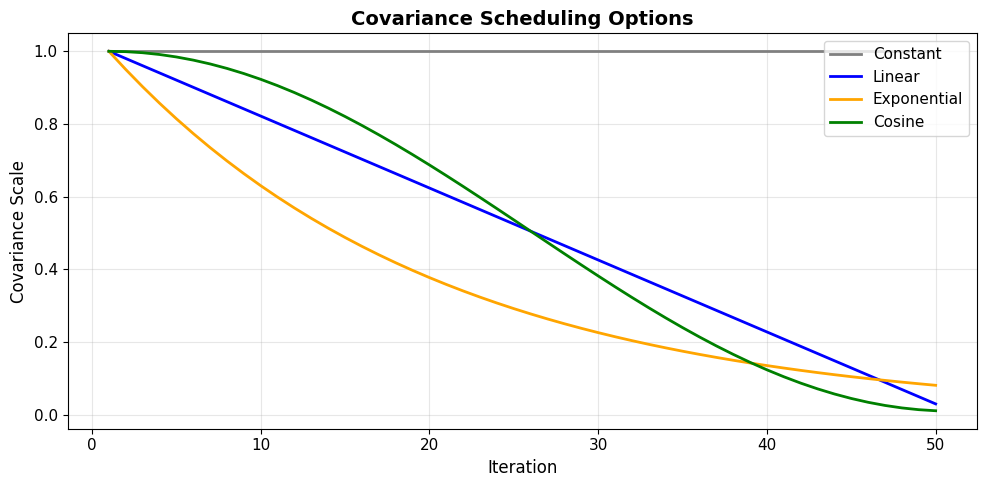

In [25]:
# Visualize covariance schedules
fig, ax = plt.subplots(figsize=(10, 5))
n_iter = 50
iters = np.arange(1, n_iter + 1)

for schedule, color, name in [
    (CovarianceSchedule.CONSTANT, 'gray', 'Constant'),
    (CovarianceSchedule.LINEAR, 'blue', 'Linear'),
    (CovarianceSchedule.EXPONENTIAL, 'orange', 'Exponential'),
    (CovarianceSchedule.COSINE, 'green', 'Cosine')]:
    scales = [compute_covariance_scale(i, n_iter, schedule) for i in iters]
    ax.plot(iters, scales, color=color, lw=2, label=name)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Covariance Scale', fontsize=12)
ax.set_title('Covariance Scheduling Options', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# ============================================================================
# NAIVE PCE (original, can bounce out of minima)
# ============================================================================
def run_pce_naive(cost_fn, y_init=0.0, sigma_init=2.0, n_samples=100, n_iterations=50,
    elite_ratio=0.1, ema_alpha=0.5, temperature=1.5, temperature_final=0.05,
    cov_schedule=CovarianceSchedule.COSINE, cov_scale_initial=1.0, cov_scale_final=0.01, cov_decay_rate=0.95):
    
    y = y_init
    n_elites = max(1, int(n_samples * elite_ratio))
    
    history = {'y': [y], 'sigma': [sigma_init * cov_scale_initial],
               'cost': [cost_fn(np.array([y]))[0]],
               'temperature': [temperature], 'samples': [], 'sample_costs': [],
               'elite_indices': [], 'elite_weights': [], 'weighted_y': []}
    
    for iteration in range(1, n_iterations + 1):
        progress = (iteration - 1) / max(1, n_iterations - 1)
        current_temp = temperature * (temperature_final / temperature) ** progress
        cov_scale = compute_covariance_scale(iteration, n_iterations, cov_schedule,
            cov_scale_initial, cov_scale_final, cov_decay_rate)
        effective_sigma = sigma_init * cov_scale
        
        # Sample around CURRENT y (problem: can drift!)
        epsilon = effective_sigma * np.random.randn(n_samples)
        samples = y + epsilon
        costs = cost_fn(samples)
        elite_indices = np.argsort(costs)[:n_elites]
        
        weights = np.zeros(n_samples)
        for m in elite_indices:
            weights[m] = np.exp(-costs[m] / current_temp)
        weights /= (np.sum(weights[elite_indices]) + 1e-10)
        x_weighted = sum(weights[m] * samples[m] for m in elite_indices)
        
        history['samples'].append(samples.copy())
        history['sample_costs'].append(costs.copy())
        history['elite_indices'].append(elite_indices.copy())
        history['elite_weights'].append(weights[elite_indices].copy())
        history['weighted_y'].append(x_weighted)
        
        y = (1 - ema_alpha) * y + ema_alpha * x_weighted
        history['y'].append(y)
        history['sigma'].append(effective_sigma)
        history['cost'].append(cost_fn(np.array([y]))[0])
        history['temperature'].append(current_temp)
    
    return history

In [27]:
# ============================================================================
# STABLE PCE (with best-so-far tracking)
# ============================================================================
def run_pce_stable(cost_fn, y_init=0.0, sigma_init=2.0, n_samples=100, n_iterations=50,
    elite_ratio=0.1, ema_alpha=0.5, temperature=1.5, temperature_final=0.05,
    cov_schedule=CovarianceSchedule.COSINE, cov_scale_initial=1.0, cov_scale_final=0.01, cov_decay_rate=0.95):
    
    y = y_init
    y_best = y_init  # KEY: Track best solution
    cost_best = cost_fn(np.array([y_init]))[0]
    n_elites = max(1, int(n_samples * elite_ratio))
    
    history = {'y': [y], 'y_best': [y_best], 'sigma': [sigma_init * cov_scale_initial],
               'cost': [cost_best], 'cost_best': [cost_best],
               'temperature': [temperature], 'samples': [], 'sample_costs': [],
               'elite_indices': [], 'elite_weights': [], 'weighted_y': []}
    
    for iteration in range(1, n_iterations + 1):
        progress = (iteration - 1) / max(1, n_iterations - 1)
        current_temp = temperature * (temperature_final / temperature) ** progress
        cov_scale = compute_covariance_scale(iteration, n_iterations, cov_schedule,
            cov_scale_initial, cov_scale_final, cov_decay_rate)
        effective_sigma = sigma_init * cov_scale
        
        # KEY FIX 1: Sample around BEST solution
        epsilon = effective_sigma * np.random.randn(n_samples)
        samples = y_best + epsilon
        costs = cost_fn(samples)
        elite_indices = np.argsort(costs)[:n_elites]
        
        weights = np.zeros(n_samples)
        for m in elite_indices:
            weights[m] = np.exp(-costs[m] / current_temp)
        weights /= (np.sum(weights[elite_indices]) + 1e-10)
        x_weighted = sum(weights[m] * samples[m] for m in elite_indices)
        
        history['samples'].append(samples.copy())
        history['sample_costs'].append(costs.copy())
        history['elite_indices'].append(elite_indices.copy())
        history['elite_weights'].append(weights[elite_indices].copy())
        history['weighted_y'].append(x_weighted)
        
        y_new = (1 - ema_alpha) * y_best + ema_alpha * x_weighted
        cost_new = cost_fn(np.array([y_new]))[0]
        
        # KEY FIX 2: Only update best if improvement
        if cost_new < cost_best:
            y_best = y_new
            cost_best = cost_new
        
        y = y_new
        history['y'].append(y)
        history['y_best'].append(y_best)
        history['sigma'].append(effective_sigma)
        history['cost'].append(cost_new)
        history['cost_best'].append(cost_best)
        history['temperature'].append(current_temp)
    
    return history

In [28]:
# ============================================================================
# NGD (Natural Gradient Descent) - with covariance scheduling
# ============================================================================
def run_ngd(cost_fn, y_init=0.0, sigma_init=2.0, n_samples=100, n_iterations=50,
    learning_rate=0.01, temperature=1.0,
    cov_schedule=CovarianceSchedule.COSINE, cov_scale_initial=1.0, cov_scale_final=0.01, cov_decay_rate=0.95):
    """Natural Gradient Descent with covariance scheduling.
    
    The covariance schedule controls the exploration radius:
    - Early: large σ for exploration
    - Late: small σ for exploitation/refinement
    """
    y = y_init
    history = {'y': [y], 'sigma': [sigma_init * cov_scale_initial],
               'cost': [cost_fn(np.array([y]))[0]],
               'samples': [], 'sample_costs': [], 'gradient': [], 'epsilon': []}
    
    for iteration in range(1, n_iterations + 1):
        # Apply covariance schedule
        cov_scale = compute_covariance_scale(iteration, n_iterations, cov_schedule,
            cov_scale_initial, cov_scale_final, cov_decay_rate)
        effective_sigma = sigma_init * cov_scale
        
        # Sample perturbations
        epsilon = effective_sigma * np.random.randn(n_samples)
        samples = y + epsilon
        costs = cost_fn(samples)
        
        # Estimate natural gradient: E[(cost/temp) * epsilon]
        natural_gradient = np.mean((costs / temperature) * epsilon)
        
        history['samples'].append(samples.copy())
        history['sample_costs'].append(costs.copy())
        history['gradient'].append(natural_gradient)
        history['epsilon'].append(epsilon.copy())
        
        # Update
        y = y - learning_rate * natural_gradient
        history['y'].append(y)
        history['sigma'].append(effective_sigma)
        history['cost'].append(cost_fn(np.array([y]))[0])
    
    return history

In [29]:
# ============================================================================
# CasADi (Gradient-based with smooth barrier approximation)
# ============================================================================
def run_casadi(cost_expr_fn, y_init=0.0, lr_init=0.5, n_iters=100, use_newton=False):
    """Run CasADi optimization.
    cost_expr_fn: function that takes CasADi symbol x and returns cost expression
    """
    x = ca.SX.sym('x')
    J = cost_expr_fn(x)
    grad_J = ca.gradient(J, x)
    hess_J = ca.hessian(J, x)[0]
    
    cost_fn = ca.Function('J', [x], [J])
    grad_fn = ca.Function('dJ', [x], [grad_J])
    hess_fn = ca.Function('ddJ', [x], [hess_J])
    
    y = y_init
    history = {'y': [y], 'cost': [float(cost_fn(y))]}
    
    lr = lr_init
    for i in range(n_iters):
        g = float(grad_fn(y))
        if use_newton:
            h = float(hess_fn(y))
            if abs(h) > 1e-10:
                y_new = y - g / h
            else:
                y_new = y - lr * g
        else:
            y_new = y - lr * g
            lr *= 0.98
        
        history['y'].append(y_new)
        history['cost'].append(float(cost_fn(y_new)))
        
        if abs(g) < 1e-10:
            break
        y = y_new
    
    return history

---
# Section 1: Simple Quadratic Cost

$$J(x) = (x - 5)^2 + 0.1 x^2$$

**Optimal:** $x^* = \frac{50}{11} \approx 4.545$, $J^* \approx 2.27$

All methods should work perfectly on this convex problem.

In [30]:
# Cost function: simple quadratic
def cost_quadratic(x, x_star=5.0, R=0.1):
    return (x - x_star)**2 + R * x**2

def casadi_cost_quadratic(x, x_star=5.0, R=0.1):
    return (x - x_star)**2 + R * x**2

X_STAR_QUAD = 50 / 11
OPT_COST_QUAD = cost_quadratic(np.array([X_STAR_QUAD]))[0]
print(f"Section 1: Simple Quadratic")
print(f"Optimal: x* = {X_STAR_QUAD:.4f}, J* = {OPT_COST_QUAD:.4f}")

Section 1: Simple Quadratic
Optimal: x* = 4.5455, J* = 2.2727


In [31]:
# Run all algorithms
np.random.seed(42)
Y_INIT = 0.0
N_ITER = 50

pce_quad = run_pce_naive(cost_quadratic, y_init=Y_INIT, sigma_init=2.0, n_iterations=N_ITER)
np.random.seed(42)
ngd_quad = run_ngd(cost_quadratic, y_init=Y_INIT, sigma_init=2.0, n_iterations=N_ITER)
casadi_quad = run_casadi(casadi_cost_quadratic, y_init=Y_INIT, use_newton=True)

print(f"PCE:    y = {pce_quad['y'][-1]:.4f}, cost = {pce_quad['cost'][-1]:.4f}")
print(f"NGD:    y = {ngd_quad['y'][-1]:.4f}, cost = {ngd_quad['cost'][-1]:.4f}")
print(f"CasADi: y = {casadi_quad['y'][-1]:.4f}, cost = {casadi_quad['cost'][-1]:.4f} ({len(casadi_quad['y'])-1} iters)")

PCE:    y = 0.0079, cost = 24.9206
NGD:    y = 0.6525, cost = 18.9431
CasADi: y = 4.5455, cost = 2.2727 (2 iters)


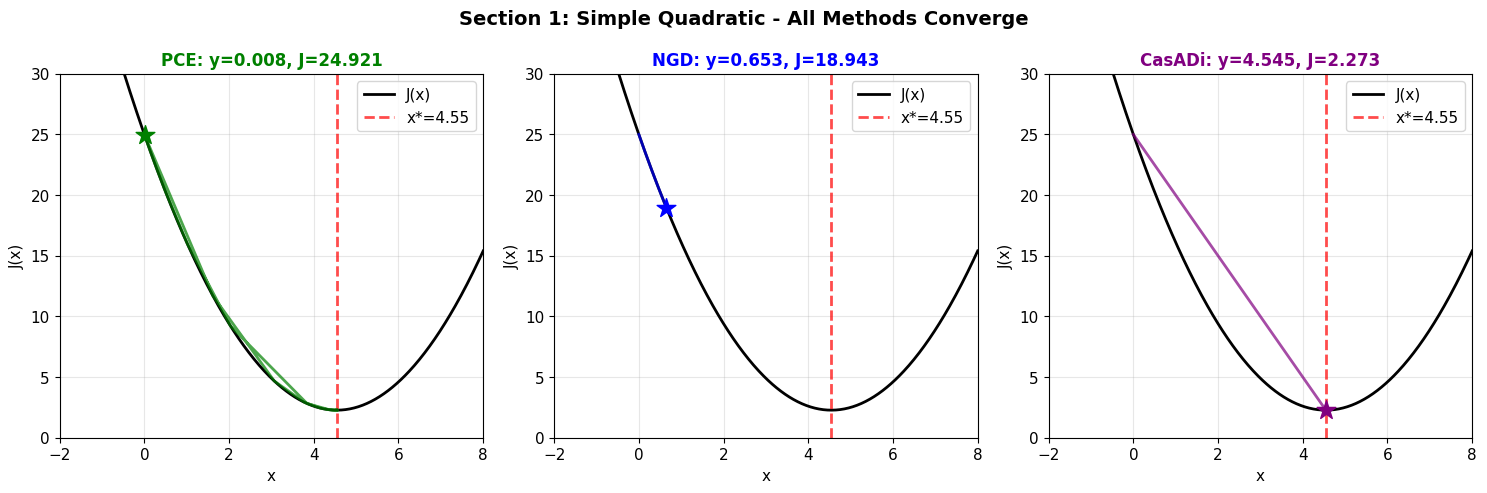

In [32]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x_plot = np.linspace(-2, 8, 500)
cost_curve = cost_quadratic(x_plot)

for ax, (hist, name, color) in zip(axes, 
    [(pce_quad, 'PCE', 'green'), (ngd_quad, 'NGD', 'blue'), (casadi_quad, 'CasADi', 'purple')]):
    ax.plot(x_plot, cost_curve, 'k-', lw=2, label='J(x)')
    ax.axvline(X_STAR_QUAD, color='red', ls='--', lw=2, alpha=0.7, label=f'x*={X_STAR_QUAD:.2f}')
    
    y_traj = hist['y']
    cost_traj = hist['cost']
    ax.plot(y_traj, cost_traj, color=color, lw=2, alpha=0.7)
    ax.scatter([y_traj[-1]], [cost_traj[-1]], c=color, s=200, marker='*', zorder=10)
    
    ax.set_xlabel('x'); ax.set_ylabel('J(x)')
    ax.set_title(f'{name}: y={y_traj[-1]:.3f}, J={cost_traj[-1]:.3f}', fontsize=12, fontweight='bold', color=color)
    ax.legend(loc='upper right'); ax.set_xlim(-2, 8); ax.set_ylim(0, 30); ax.grid(True, alpha=0.3)

plt.suptitle('Section 1: Simple Quadratic - All Methods Converge', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Section 2: Quadratic + One Barrier

$$J(x) = (x - 5)^2 + 0.1 x^2 + 100 \cdot \mathbf{1}_{(2,3)}(x)$$

**Barrier region:** $x \in (2, 3)$ has cost +100

**Optimal:** Still $x^* \approx 4.545$ (on right side of barrier)

**Challenge:** Starting from $x=0$, algorithms must cross the barrier.

In [33]:
# Cost function: quadratic + one barrier
def cost_one_barrier(x, x_star=5.0, R=0.1, barrier_val=100.0):
    base = (x - x_star)**2 + R * x**2
    barrier = np.where((x > 2) & (x < 3), barrier_val, 0.0)
    return base + barrier

def casadi_cost_one_barrier(x, x_star=5.0, R=0.1, k=20):
    """Smooth approximation of barrier using sigmoid"""
    base = (x - x_star)**2 + R * x**2
    barrier = 100.0 * (1 / (1 + ca.exp(-k*(x - 2)))) * (1 / (1 + ca.exp(k*(x - 3))))
    return base + barrier

X_STAR_1B = 50 / 11
OPT_COST_1B = cost_one_barrier(np.array([X_STAR_1B]))[0]
print(f"Section 2: Quadratic + One Barrier at (2,3)")
print(f"Optimal: x* = {X_STAR_1B:.4f}, J* = {OPT_COST_1B:.4f}")

Section 2: Quadratic + One Barrier at (2,3)
Optimal: x* = 4.5455, J* = 2.2727


In [34]:
# Run from y=0 (must cross barrier)
np.random.seed(42)
Y_INIT = 0.0

pce_1b = run_pce_naive(cost_one_barrier, y_init=Y_INIT, sigma_init=2.0, n_iterations=N_ITER)
np.random.seed(42)
ngd_1b = run_ngd(cost_one_barrier, y_init=Y_INIT, sigma_init=2.0, n_iterations=N_ITER)
casadi_1b = run_casadi(casadi_cost_one_barrier, y_init=Y_INIT)

# Get true cost for CasADi
casadi_1b_true_cost = [cost_one_barrier(np.array([y]))[0] for y in casadi_1b['y']]

print(f"PCE:    y = {pce_1b['y'][-1]:.4f}, cost = {pce_1b['cost'][-1]:.4f}")
print(f"NGD:    y = {ngd_1b['y'][-1]:.4f}, cost = {ngd_1b['cost'][-1]:.4f}")
print(f"CasADi: y = {casadi_1b['y'][-1]:.4f}, TRUE cost = {casadi_1b_true_cost[-1]:.4f}")

PCE:    y = 0.0079, cost = 24.9206
NGD:    y = 0.2043, cost = 23.0025
CasADi: y = 4.5455, TRUE cost = 2.2727


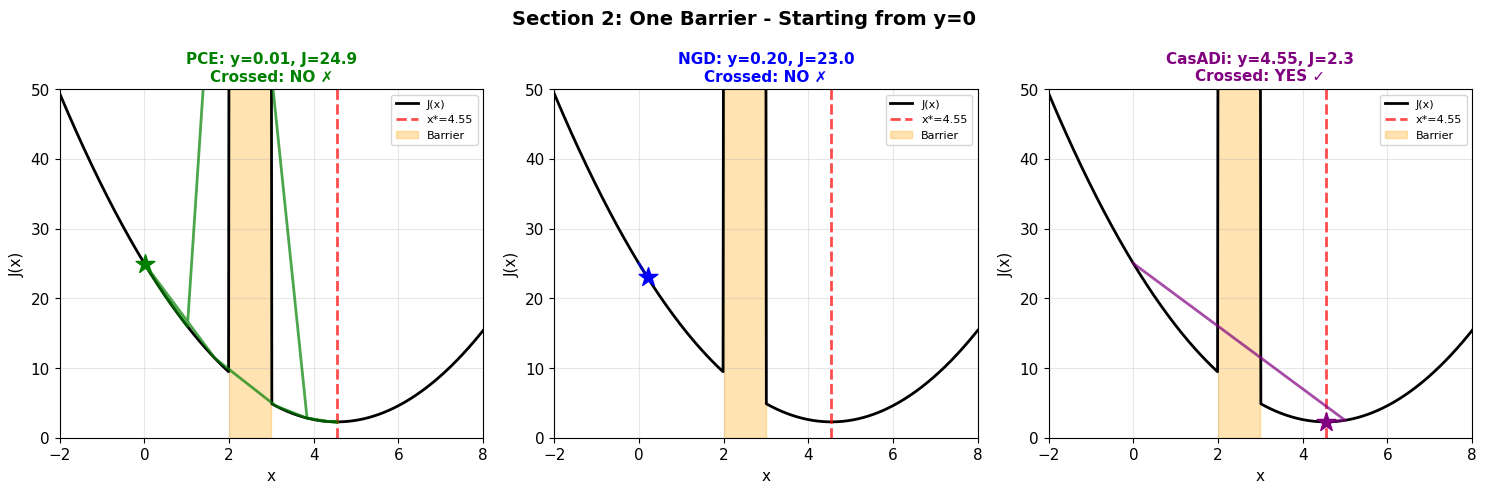

In [35]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x_plot = np.linspace(-2, 8, 500)
cost_curve = cost_one_barrier(x_plot)

for ax, (hist, true_cost, name, color) in zip(axes, 
    [(pce_1b, pce_1b['cost'], 'PCE', 'green'), 
     (ngd_1b, ngd_1b['cost'], 'NGD', 'blue'), 
     (casadi_1b, casadi_1b_true_cost, 'CasADi', 'purple')]):
    ax.plot(x_plot, cost_curve, 'k-', lw=2, label='J(x)')
    ax.axvline(X_STAR_1B, color='red', ls='--', lw=2, alpha=0.7, label=f'x*={X_STAR_1B:.2f}')
    ax.axvspan(2, 3, alpha=0.3, color='orange', label='Barrier')
    
    y_traj = hist['y']
    ax.plot(y_traj, true_cost, color=color, lw=2, alpha=0.7)
    ax.scatter([y_traj[-1]], [true_cost[-1]], c=color, s=200, marker='*', zorder=10)
    
    crossed = 'YES ✓' if y_traj[-1] > 3 else 'NO ✗'
    ax.set_xlabel('x'); ax.set_ylabel('J(x)')
    ax.set_title(f'{name}: y={y_traj[-1]:.2f}, J={true_cost[-1]:.1f}\nCrossed: {crossed}', 
                 fontsize=11, fontweight='bold', color=color)
    ax.legend(loc='upper right', fontsize=8); ax.set_xlim(-2, 8); ax.set_ylim(0, 50); ax.grid(True, alpha=0.3)

plt.suptitle('Section 2: One Barrier - Starting from y=0', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Section 3: Quadratic + Two Barriers

$$J(x) = (x - 5)^2 + 0.1 x^2 + 100 \cdot \mathbf{1}_{(2,3)}(x) + 100 \cdot \mathbf{1}_{(6,8)}(x)$$

**Barrier regions:** $x \in (2, 3)$ and $x \in (6, 8)$

**Optimal:** $x^* \approx 4.545$ (in the "safe corridor" between barriers)

**Challenge:** CasADi's smooth approximation creates artificial local minima!

In [36]:
# Cost function: quadratic + two barriers
def cost_two_barriers(x, x_star=5.0, R=0.1, barrier_val=100.0):
    base = (x - x_star)**2 + R * x**2
    b1 = np.where((x > 2) & (x < 3), barrier_val, 0.0)
    b2 = np.where((x > 6) & (x < 8), barrier_val, 0.0)
    return base + b1 + b2

def casadi_cost_two_barriers(x, x_star=5.0, R=0.1, k=2):
    """Smooth approximation - k=2 creates local minima!"""
    base = (x - x_star)**2 + R * x**2
    b1 = 100.0 * (1 / (1 + ca.exp(-k*(x - 2)))) * (1 / (1 + ca.exp(k*(x - 3))))
    b2 = 100.0 * (1 / (1 + ca.exp(-k*(x - 6)))) * (1 / (1 + ca.exp(k*(x - 8))))
    return base + b1 + b2

X_STAR_2B = 50 / 11
OPT_COST_2B = cost_two_barriers(np.array([X_STAR_2B]))[0]
print(f"Section 3: Quadratic + Two Barriers at (2,3) and (6,8)")
print(f"Optimal: x* = {X_STAR_2B:.4f}, J* = {OPT_COST_2B:.4f}")

Section 3: Quadratic + Two Barriers at (2,3) and (6,8)
Optimal: x* = 4.5455, J* = 2.2727


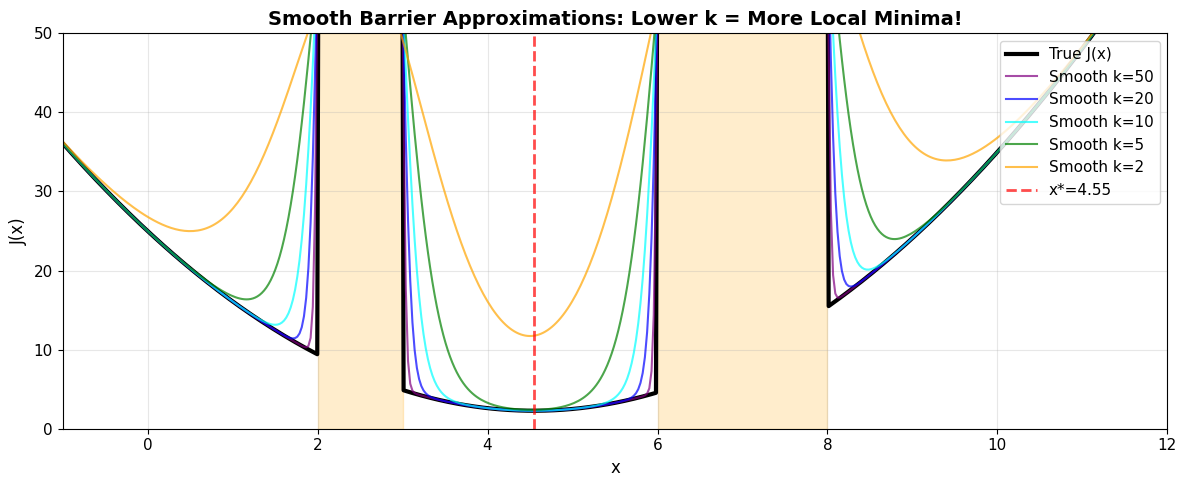

In [37]:
# Visualize the smooth approximation problem
fig, ax = plt.subplots(figsize=(12, 5))
x_plot = np.linspace(-1, 12, 500)

ax.plot(x_plot, cost_two_barriers(x_plot), 'k-', lw=3, label='True J(x)')

for k, color in [(50, 'purple'), (20, 'blue'), (10, 'cyan'), (5, 'green'), (2, 'orange')]:
    smooth = np.array([(xv - 5)**2 + 0.1 * xv**2 + 
                       100.0 / (1 + np.exp(-k*(xv - 2))) / (1 + np.exp(k*(xv - 3))) +
                       100.0 / (1 + np.exp(-k*(xv - 6))) / (1 + np.exp(k*(xv - 8)))
                       for xv in x_plot])
    ax.plot(x_plot, smooth, color=color, lw=1.5, alpha=0.7, label=f'Smooth k={k}')

ax.axvline(X_STAR_2B, color='red', ls='--', lw=2, alpha=0.7, label=f'x*={X_STAR_2B:.2f}')
ax.axvspan(2, 3, alpha=0.2, color='orange')
ax.axvspan(6, 8, alpha=0.2, color='orange')
ax.set_xlabel('x', fontsize=12); ax.set_ylabel('J(x)', fontsize=12)
ax.set_title('Smooth Barrier Approximations: Lower k = More Local Minima!', fontsize=14, fontweight='bold')
ax.legend(loc='upper right'); ax.set_xlim(-1, 12); ax.set_ylim(0, 50); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
# Run from y=9.5 (in local minimum basin for CasADi k=2)
np.random.seed(42)
Y_INIT = 9.5

pce_2b = run_pce_stable(cost_two_barriers, y_init=Y_INIT, sigma_init=3.0, n_iterations=N_ITER)
np.random.seed(42)
ngd_2b = run_ngd(cost_two_barriers, y_init=Y_INIT, sigma_init=3.0, n_iterations=N_ITER)
casadi_2b = run_casadi(casadi_cost_two_barriers, y_init=Y_INIT, lr_init=0.3)

casadi_2b_true_cost = [cost_two_barriers(np.array([y]))[0] for y in casadi_2b['y']]

print(f"Starting from y = {Y_INIT} (in local min basin for CasADi k=2)")
print(f"PCE (stable): y_best = {pce_2b['y_best'][-1]:.4f}, cost_best = {pce_2b['cost_best'][-1]:.4f}")
print(f"NGD:          y = {ngd_2b['y'][-1]:.4f}, cost = {ngd_2b['cost'][-1]:.4f}")
print(f"CasADi (k=2): y = {casadi_2b['y'][-1]:.4f}, TRUE cost = {casadi_2b_true_cost[-1]:.4f}")

Starting from y = 9.5 (in local min basin for CasADi k=2)
PCE (stable): y_best = 4.5457, cost_best = 2.2727
NGD:          y = 9.0895, cost = 24.9861
CasADi (k=2): y = 9.4049, TRUE cost = 28.2482


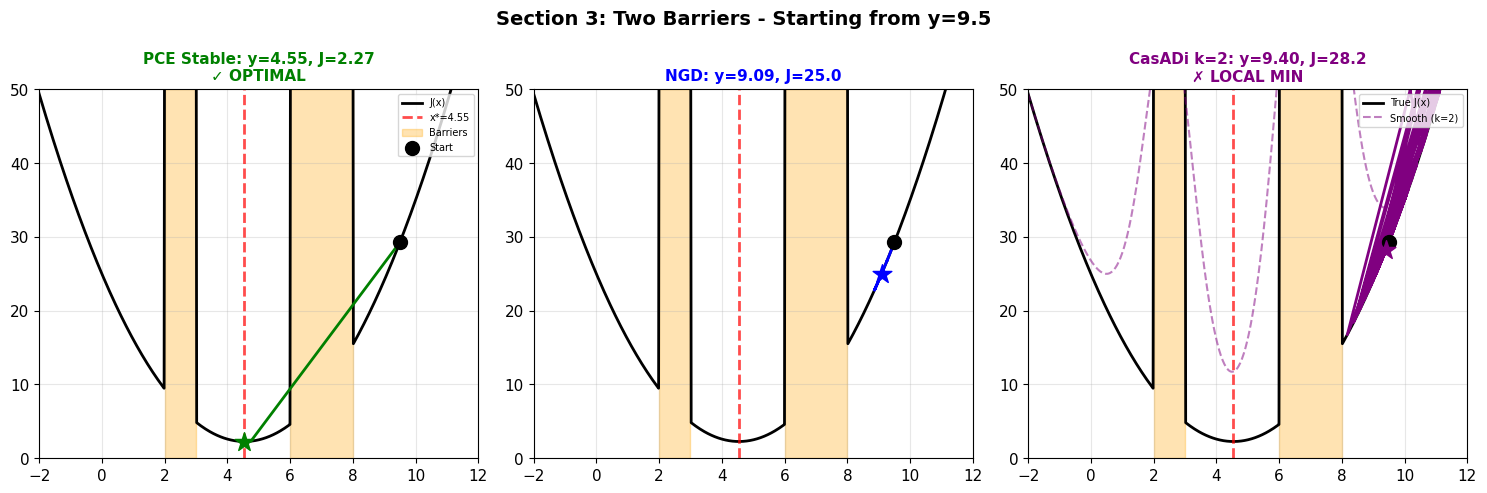

In [39]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
x_plot = np.linspace(-2, 12, 500)
cost_curve = cost_two_barriers(x_plot)

# PCE
ax = axes[0]
ax.plot(x_plot, cost_curve, 'k-', lw=2, label='J(x)')
ax.axvline(X_STAR_2B, color='red', ls='--', lw=2, alpha=0.7, label=f'x*={X_STAR_2B:.2f}')
ax.axvspan(2, 3, alpha=0.3, color='orange', label='Barriers')
ax.axvspan(6, 8, alpha=0.3, color='orange')
ax.scatter([Y_INIT], [cost_two_barriers(np.array([Y_INIT]))[0]], c='black', s=100, marker='o', label='Start', zorder=5)
ax.plot(pce_2b['y_best'], pce_2b['cost_best'], 'g-', lw=2)
ax.scatter([pce_2b['y_best'][-1]], [pce_2b['cost_best'][-1]], c='green', s=200, marker='*', zorder=10)
ax.set_title(f'PCE Stable: y={pce_2b["y_best"][-1]:.2f}, J={pce_2b["cost_best"][-1]:.2f}\n✓ OPTIMAL', 
             fontsize=11, fontweight='bold', color='green')
ax.legend(loc='upper right', fontsize=7); ax.set_xlim(-2, 12); ax.set_ylim(0, 50); ax.grid(True, alpha=0.3)

# NGD
ax = axes[1]
ax.plot(x_plot, cost_curve, 'k-', lw=2)
ax.axvline(X_STAR_2B, color='red', ls='--', lw=2, alpha=0.7)
ax.axvspan(2, 3, alpha=0.3, color='orange')
ax.axvspan(6, 8, alpha=0.3, color='orange')
ax.scatter([Y_INIT], [cost_two_barriers(np.array([Y_INIT]))[0]], c='black', s=100, marker='o', zorder=5)
ax.plot(ngd_2b['y'], ngd_2b['cost'], 'b-', lw=2)
ax.scatter([ngd_2b['y'][-1]], [ngd_2b['cost'][-1]], c='blue', s=200, marker='*', zorder=10)
ax.set_title(f'NGD: y={ngd_2b["y"][-1]:.2f}, J={ngd_2b["cost"][-1]:.1f}', 
             fontsize=11, fontweight='bold', color='blue')
ax.set_xlim(-2, 12); ax.set_ylim(0, 50); ax.grid(True, alpha=0.3)

# CasADi
ax = axes[2]
ax.plot(x_plot, cost_curve, 'k-', lw=2, label='True J(x)')
smooth_cost = np.array([(xv - 5)**2 + 0.1 * xv**2 + 
                        100.0 / (1 + np.exp(-2*(xv - 2))) / (1 + np.exp(2*(xv - 3))) +
                        100.0 / (1 + np.exp(-2*(xv - 6))) / (1 + np.exp(2*(xv - 8)))
                        for xv in x_plot])
ax.plot(x_plot, smooth_cost, 'purple', lw=1.5, ls='--', alpha=0.5, label='Smooth (k=2)')
ax.axvline(X_STAR_2B, color='red', ls='--', lw=2, alpha=0.7)
ax.axvspan(2, 3, alpha=0.3, color='orange')
ax.axvspan(6, 8, alpha=0.3, color='orange')
ax.scatter([Y_INIT], [cost_two_barriers(np.array([Y_INIT]))[0]], c='black', s=100, marker='o', zorder=5)
ax.plot(casadi_2b['y'], casadi_2b_true_cost, 'purple', lw=2)
ax.scatter([casadi_2b['y'][-1]], [casadi_2b_true_cost[-1]], c='purple', s=200, marker='*', zorder=10)
ax.set_title(f'CasADi k=2: y={casadi_2b["y"][-1]:.2f}, J={casadi_2b_true_cost[-1]:.1f}\n✗ LOCAL MIN', 
             fontsize=11, fontweight='bold', color='purple')
ax.legend(loc='upper right', fontsize=7); ax.set_xlim(-2, 12); ax.set_ylim(0, 50); ax.grid(True, alpha=0.3)

plt.suptitle(f'Section 3: Two Barriers - Starting from y={Y_INIT}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Section 4: PCE Stability - Naive vs Best-Preserving

**Problem:** Naive PCE can find the optimum but then "bounce out" due to:
1. Sampling around current (possibly bad) position
2. Outliers in barrier regions pulling the weighted mean

**Solution:** Best-so-far tracking ensures:
- Always sample around the best known solution
- Never regress: cost_best is monotonically non-increasing

In [40]:
# Compare Naive vs Stable PCE on two-barrier problem
np.random.seed(42)
Y_INIT = 9.5

pce_naive = run_pce_naive(cost_two_barriers, y_init=Y_INIT, sigma_init=3.0, n_iterations=N_ITER)
np.random.seed(42)
pce_stable = run_pce_stable(cost_two_barriers, y_init=Y_INIT, sigma_init=3.0, n_iterations=N_ITER)

print(f"Starting from y = {Y_INIT}")
print(f"")
print(f"PCE Naive:")
print(f"  Final y = {pce_naive['y'][-1]:.4f}")
print(f"  Final cost = {pce_naive['cost'][-1]:.4f}")
print(f"  Best cost found = {min(pce_naive['cost']):.4f} at iter {np.argmin(pce_naive['cost'])}")
print(f"")
print(f"PCE Stable (best-so-far):")
print(f"  Final y_best = {pce_stable['y_best'][-1]:.4f}")
print(f"  Final cost_best = {pce_stable['cost_best'][-1]:.4f}")

Starting from y = 9.5

PCE Naive:
  Final y = 0.0088
  Final cost = 24.9117
  Best cost found = 2.2727 at iter 17

PCE Stable (best-so-far):
  Final y_best = 4.5457
  Final cost_best = 2.2727


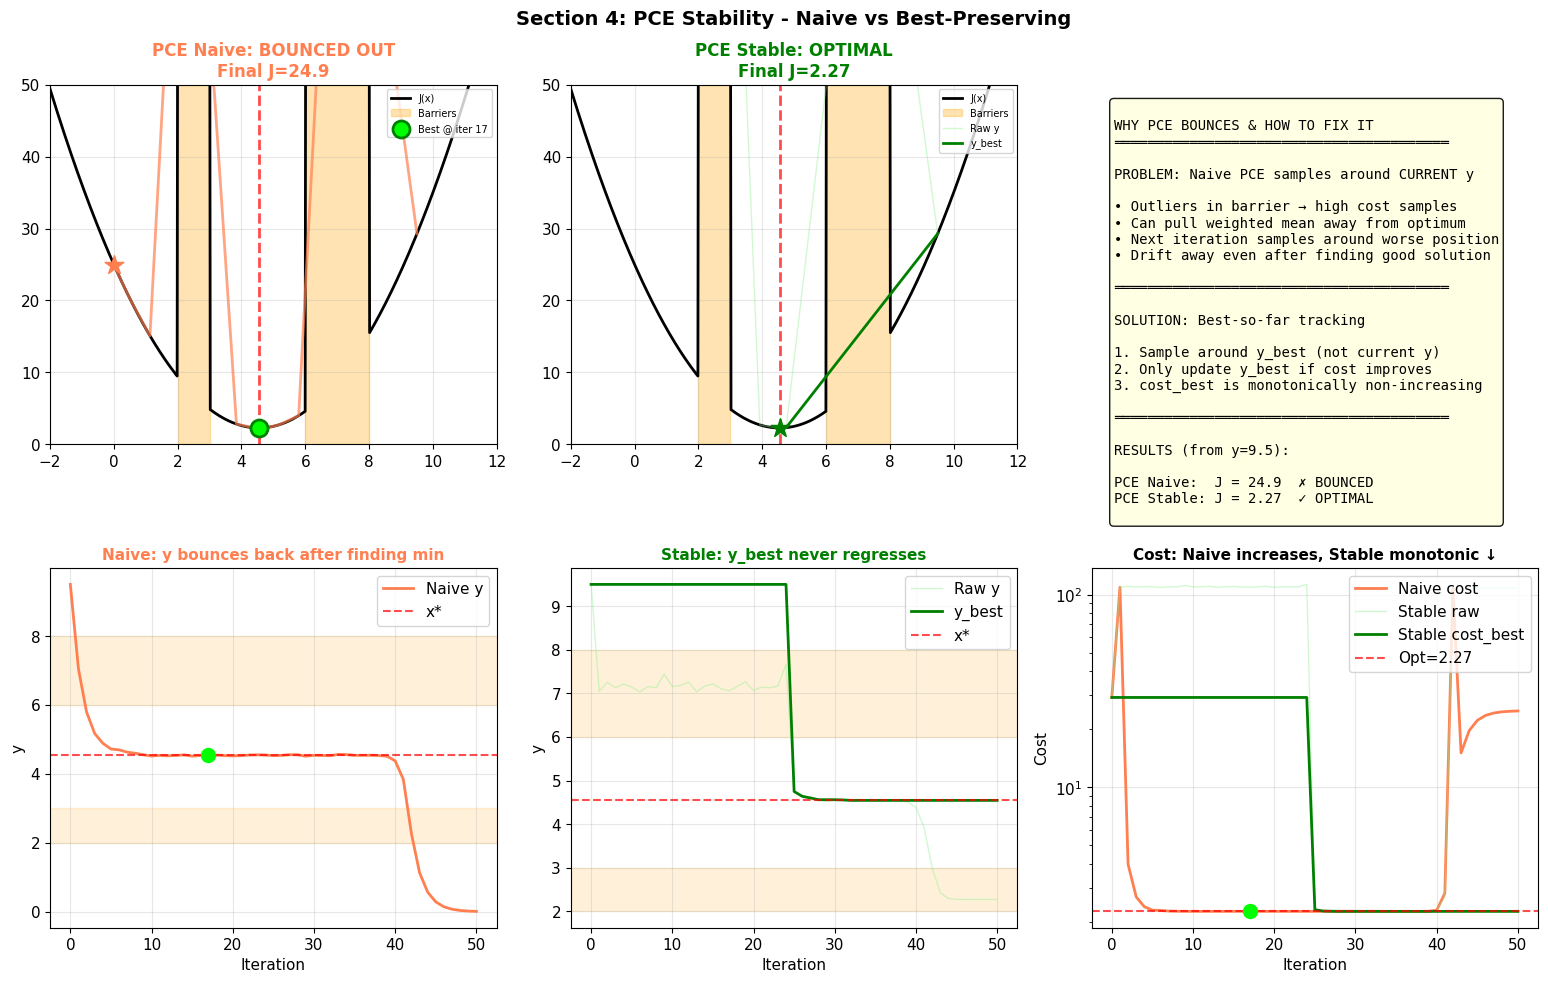

In [41]:
# Visualization: Naive vs Stable
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig)

x_plot = np.linspace(-2, 12, 500)
cost_curve = cost_two_barriers(x_plot)

# TOP LEFT: Naive PCE cost landscape
ax = fig.add_subplot(gs[0, 0])
ax.plot(x_plot, cost_curve, 'k-', lw=2, label='J(x)')
ax.axvline(X_STAR_2B, color='red', ls='--', lw=2, alpha=0.7)
ax.axvspan(2, 3, alpha=0.3, color='orange', label='Barriers')
ax.axvspan(6, 8, alpha=0.3, color='orange')
ax.plot(pce_naive['y'], pce_naive['cost'], 'coral', lw=2, alpha=0.7)
ax.scatter([pce_naive['y'][-1]], [pce_naive['cost'][-1]], c='coral', s=200, marker='*', zorder=10)
min_idx = np.argmin(pce_naive['cost'])
ax.scatter([pce_naive['y'][min_idx]], [pce_naive['cost'][min_idx]], c='lime', s=150, marker='o', 
           edgecolors='green', linewidths=2, zorder=9, label=f'Best @ iter {min_idx}')
ax.set_title(f'PCE Naive: BOUNCED OUT\nFinal J={pce_naive["cost"][-1]:.1f}', fontsize=12, fontweight='bold', color='coral')
ax.legend(loc='upper right', fontsize=7); ax.set_xlim(-2, 12); ax.set_ylim(0, 50); ax.grid(True, alpha=0.3)

# TOP MIDDLE: Stable PCE cost landscape
ax = fig.add_subplot(gs[0, 1])
ax.plot(x_plot, cost_curve, 'k-', lw=2, label='J(x)')
ax.axvline(X_STAR_2B, color='red', ls='--', lw=2, alpha=0.7)
ax.axvspan(2, 3, alpha=0.3, color='orange', label='Barriers')
ax.axvspan(6, 8, alpha=0.3, color='orange')
ax.plot(pce_stable['y'], pce_stable['cost'], 'lightgreen', lw=1, alpha=0.4, label='Raw y')
ax.plot(pce_stable['y_best'], pce_stable['cost_best'], 'green', lw=2, label='y_best')
ax.scatter([pce_stable['y_best'][-1]], [pce_stable['cost_best'][-1]], c='green', s=200, marker='*', zorder=10)
ax.set_title(f'PCE Stable: OPTIMAL\nFinal J={pce_stable["cost_best"][-1]:.2f}', fontsize=12, fontweight='bold', color='green')
ax.legend(loc='upper right', fontsize=7); ax.set_xlim(-2, 12); ax.set_ylim(0, 50); ax.grid(True, alpha=0.3)

# TOP RIGHT: Summary
ax = fig.add_subplot(gs[0, 2])
ax.axis('off')
summary = f'''
WHY PCE BOUNCES & HOW TO FIX IT
════════════════════════════════════════

PROBLEM: Naive PCE samples around CURRENT y

• Outliers in barrier → high cost samples
• Can pull weighted mean away from optimum
• Next iteration samples around worse position
• Drift away even after finding good solution

════════════════════════════════════════

SOLUTION: Best-so-far tracking

1. Sample around y_best (not current y)
2. Only update y_best if cost improves
3. cost_best is monotonically non-increasing

════════════════════════════════════════

RESULTS (from y={Y_INIT}):

PCE Naive:  J = {pce_naive['cost'][-1]:.1f}  ✗ BOUNCED
PCE Stable: J = {pce_stable['cost_best'][-1]:.2f}  ✓ OPTIMAL
'''
ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

# BOTTOM LEFT: y trajectory comparison
ax = fig.add_subplot(gs[1, 0])
ax.plot(pce_naive['y'], 'coral', lw=2, label='Naive y')
ax.axhline(X_STAR_2B, color='red', ls='--', lw=1.5, alpha=0.7, label='x*')
ax.axhspan(2, 3, alpha=0.15, color='orange')
ax.axhspan(6, 8, alpha=0.15, color='orange')
ax.scatter([min_idx], [pce_naive['y'][min_idx]], c='lime', s=100, zorder=5)
ax.set_xlabel('Iteration'); ax.set_ylabel('y')
ax.set_title('Naive: y bounces back after finding min', fontsize=11, fontweight='bold', color='coral')
ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

# BOTTOM MIDDLE: Stable y trajectory
ax = fig.add_subplot(gs[1, 1])
ax.plot(pce_stable['y'], 'lightgreen', lw=1, alpha=0.4, label='Raw y')
ax.plot(pce_stable['y_best'], 'green', lw=2, label='y_best')
ax.axhline(X_STAR_2B, color='red', ls='--', lw=1.5, alpha=0.7, label='x*')
ax.axhspan(2, 3, alpha=0.15, color='orange')
ax.axhspan(6, 8, alpha=0.15, color='orange')
ax.set_xlabel('Iteration'); ax.set_ylabel('y')
ax.set_title('Stable: y_best never regresses', fontsize=11, fontweight='bold', color='green')
ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

# BOTTOM RIGHT: Cost convergence
ax = fig.add_subplot(gs[1, 2])
ax.plot(pce_naive['cost'], 'coral', lw=2, label='Naive cost')
ax.plot(pce_stable['cost'], 'lightgreen', lw=1, alpha=0.4, label='Stable raw')
ax.plot(pce_stable['cost_best'], 'green', lw=2, label='Stable cost_best')
ax.axhline(OPT_COST_2B, color='red', ls='--', lw=1.5, alpha=0.7, label=f'Opt={OPT_COST_2B:.2f}')
ax.scatter([min_idx], [pce_naive['cost'][min_idx]], c='lime', s=100, zorder=5)
ax.set_xlabel('Iteration'); ax.set_ylabel('Cost')
ax.set_title('Cost: Naive increases, Stable monotonic ↓', fontsize=11, fontweight='bold')
ax.set_yscale('log'); ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

plt.suptitle('Section 4: PCE Stability - Naive vs Best-Preserving', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
# Section 5: Covariance Scheduling Comparison

Compare how different covariance schedules affect PCE and NGD convergence.

**Schedules:**
- **Constant:** σ stays fixed (good for exploration, may not converge tightly)
- **Linear:** σ decreases linearly (simple annealing)
- **Exponential:** σ = σ₀ × decay^t (fast initial decay)
- **Cosine:** Smooth decrease following cosine curve (best of both worlds)

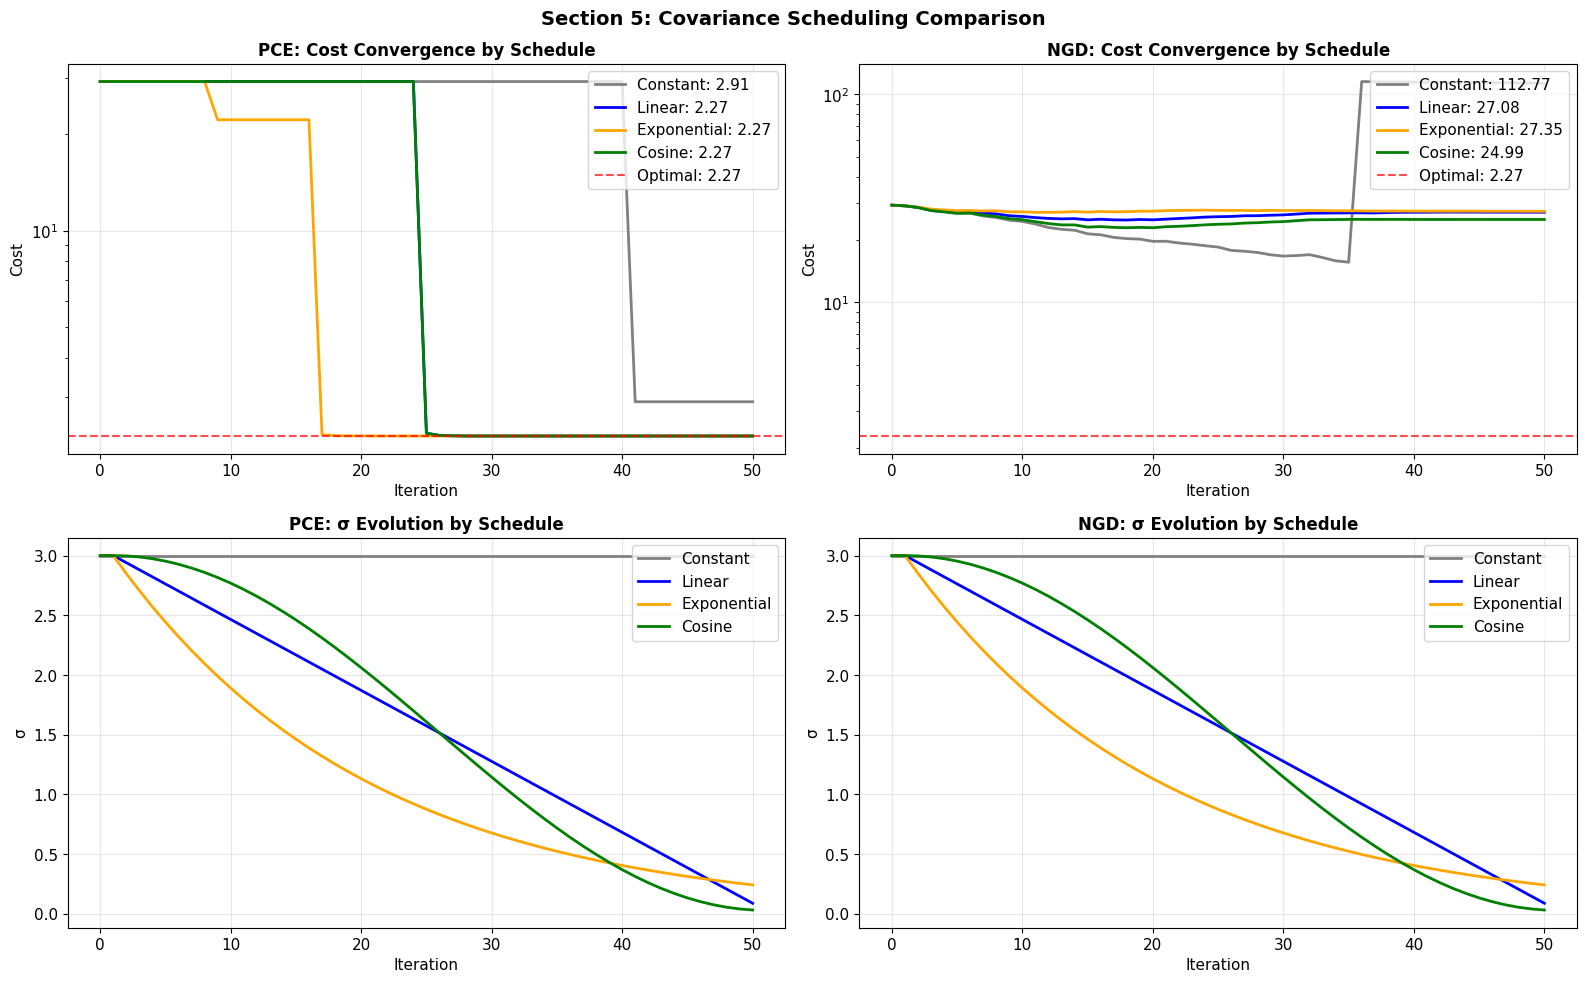


COVARIANCE SCHEDULE COMPARISON SUMMARY

Optimal: x*=4.5455, J*=2.2727

Schedule        PCE Final Cost     NGD Final Cost    
---------------------------------------------------
Constant        2.9090             112.7734          
Linear          2.2727             27.0767           
Exponential     2.2727             27.3479           
Cosine          2.2727             24.9861           


In [42]:
# Compare schedules on the two-barrier problem
Y_INIT = 9.5
N_ITER = 50
SIGMA = 3.0

schedules = [
    (CovarianceSchedule.CONSTANT, 'Constant', 'gray'),
    (CovarianceSchedule.LINEAR, 'Linear', 'blue'),
    (CovarianceSchedule.EXPONENTIAL, 'Exponential', 'orange'),
    (CovarianceSchedule.COSINE, 'Cosine', 'green')
]

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig)

# Run and collect results
pce_results = {}
ngd_results = {}

for schedule, name, color in schedules:
    np.random.seed(42)
    pce_results[name] = run_pce_stable(cost_two_barriers, y_init=Y_INIT, sigma_init=SIGMA,
                                        n_iterations=N_ITER, cov_schedule=schedule)
    np.random.seed(42)
    ngd_results[name] = run_ngd(cost_two_barriers, y_init=Y_INIT, sigma_init=SIGMA,
                                 n_iterations=N_ITER, cov_schedule=schedule)

# TOP LEFT: PCE cost convergence
ax = fig.add_subplot(gs[0, 0])
for schedule, name, color in schedules:
    ax.plot(pce_results[name]['cost_best'], color=color, lw=2, label=f'{name}: {pce_results[name]["cost_best"][-1]:.2f}')
ax.axhline(OPT_COST_2B, color='red', ls='--', lw=1.5, alpha=0.7, label=f'Optimal: {OPT_COST_2B:.2f}')
ax.set_xlabel('Iteration'); ax.set_ylabel('Cost')
ax.set_title('PCE: Cost Convergence by Schedule', fontsize=12, fontweight='bold')
ax.set_yscale('log'); ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

# TOP RIGHT: NGD cost convergence
ax = fig.add_subplot(gs[0, 1])
for schedule, name, color in schedules:
    ax.plot(ngd_results[name]['cost'], color=color, lw=2, label=f'{name}: {ngd_results[name]["cost"][-1]:.2f}')
ax.axhline(OPT_COST_2B, color='red', ls='--', lw=1.5, alpha=0.7, label=f'Optimal: {OPT_COST_2B:.2f}')
ax.set_xlabel('Iteration'); ax.set_ylabel('Cost')
ax.set_title('NGD: Cost Convergence by Schedule', fontsize=12, fontweight='bold')
ax.set_yscale('log'); ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

# BOTTOM LEFT: PCE sigma evolution
ax = fig.add_subplot(gs[1, 0])
for schedule, name, color in schedules:
    ax.plot(pce_results[name]['sigma'], color=color, lw=2, label=name)
ax.set_xlabel('Iteration'); ax.set_ylabel('σ')
ax.set_title('PCE: σ Evolution by Schedule', fontsize=12, fontweight='bold')
ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

# BOTTOM RIGHT: NGD sigma evolution
ax = fig.add_subplot(gs[1, 1])
for schedule, name, color in schedules:
    ax.plot(ngd_results[name]['sigma'], color=color, lw=2, label=name)
ax.set_xlabel('Iteration'); ax.set_ylabel('σ')
ax.set_title('NGD: σ Evolution by Schedule', fontsize=12, fontweight='bold')
ax.legend(loc='upper right'); ax.grid(True, alpha=0.3)

plt.suptitle('Section 5: Covariance Scheduling Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("COVARIANCE SCHEDULE COMPARISON SUMMARY")
print("="*60)
print(f"\nOptimal: x*={X_STAR_2B:.4f}, J*={OPT_COST_2B:.4f}")
print(f"\n{'Schedule':<15} {'PCE Final Cost':<18} {'NGD Final Cost':<18}")
print("-"*51)
for schedule, name, color in schedules:
    pce_cost = pce_results[name]['cost_best'][-1]
    ngd_cost = ngd_results[name]['cost'][-1]
    print(f"{name:<15} {pce_cost:<18.4f} {ngd_cost:<18.4f}")

---
# Interactive Exploration

Explore different scenarios with adjustable parameters including covariance scheduling.

In [43]:
def interactive_comparison(y_init, sigma, n_iterations, problem, cov_schedule_name, cov_decay_rate):
    # Select cost function
    if problem == 'Quadratic':
        cost_fn = cost_quadratic
        casadi_fn = casadi_cost_quadratic
        x_star = X_STAR_QUAD
        opt_cost = OPT_COST_QUAD
        barriers = []
    elif problem == 'One Barrier':
        cost_fn = cost_one_barrier
        casadi_fn = casadi_cost_one_barrier
        x_star = X_STAR_1B
        opt_cost = OPT_COST_1B
        barriers = [(2, 3)]
    else:  # Two Barriers
        cost_fn = cost_two_barriers
        casadi_fn = casadi_cost_two_barriers
        x_star = X_STAR_2B
        opt_cost = OPT_COST_2B
        barriers = [(2, 3), (6, 8)]
    
    # Map schedule name to enum
    schedule_map = {'Constant': CovarianceSchedule.CONSTANT, 'Linear': CovarianceSchedule.LINEAR,
                    'Exponential': CovarianceSchedule.EXPONENTIAL, 'Cosine': CovarianceSchedule.COSINE}
    cov_schedule = schedule_map[cov_schedule_name]
    
    # Run algorithms
    np.random.seed(42)
    pce = run_pce_stable(cost_fn, y_init=y_init, sigma_init=sigma, n_iterations=n_iterations,
                         cov_schedule=cov_schedule, cov_decay_rate=cov_decay_rate)
    np.random.seed(42)
    ngd = run_ngd(cost_fn, y_init=y_init, sigma_init=sigma, n_iterations=n_iterations,
                  cov_schedule=cov_schedule, cov_decay_rate=cov_decay_rate)
    casadi = run_casadi(casadi_fn, y_init=y_init)
    casadi_true = [cost_fn(np.array([y]))[0] for y in casadi['y']]
    
    # Plot
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 3, figure=fig, height_ratios=[1.2, 0.8, 0.8])
    x_plot = np.linspace(-2, 12, 500)
    cost_curve = cost_fn(x_plot)
    
    # Top row: Cost landscape
    for idx, (hist, true_cost, name, color) in enumerate([
        (pce, pce['cost_best'], 'PCE Stable', 'green'),
        (ngd, ngd['cost'], 'NGD', 'blue'),
        (casadi, casadi_true, 'CasADi', 'purple')]):
        ax = fig.add_subplot(gs[0, idx])
        ax.plot(x_plot, cost_curve, 'k-', lw=2)
        ax.axvline(x_star, color='red', ls='--', lw=2, alpha=0.7)
        for b in barriers:
            ax.axvspan(b[0], b[1], alpha=0.3, color='orange')
        ax.scatter([y_init], [cost_fn(np.array([y_init]))[0]], c='black', s=100, marker='o', zorder=5)
        
        y_traj = hist['y_best'] if 'y_best' in hist else hist['y']
        ax.plot(y_traj, true_cost, color=color, lw=2)
        ax.scatter([y_traj[-1]], [true_cost[-1]], c=color, s=200, marker='*', zorder=10)
        
        ax.set_title(f'{name}\ny={y_traj[-1]:.2f}, J={true_cost[-1]:.2f}', fontsize=11, fontweight='bold', color=color)
        ax.set_xlim(-2, 12); ax.set_ylim(0, 60); ax.grid(True, alpha=0.3)
    
    # Middle row: Cost convergence
    ax = fig.add_subplot(gs[1, 0])
    ax.plot(pce['cost_best'], 'g-', lw=2)
    ax.axhline(opt_cost, color='red', ls='--', alpha=0.7, label=f'Opt={opt_cost:.2f}')
    ax.set_yscale('log'); ax.set_title('PCE Cost', color='green', fontweight='bold')
    ax.set_xlabel('Iteration'); ax.set_ylabel('Cost'); ax.legend(); ax.grid(True, alpha=0.3)
    
    ax = fig.add_subplot(gs[1, 1])
    ax.plot(ngd['cost'], 'b-', lw=2)
    ax.axhline(opt_cost, color='red', ls='--', alpha=0.7, label=f'Opt={opt_cost:.2f}')
    ax.set_yscale('log'); ax.set_title('NGD Cost', color='blue', fontweight='bold')
    ax.set_xlabel('Iteration'); ax.set_ylabel('Cost'); ax.legend(); ax.grid(True, alpha=0.3)
    
    ax = fig.add_subplot(gs[1, 2])
    ax.plot(casadi_true, 'purple', lw=2)
    ax.axhline(opt_cost, color='red', ls='--', alpha=0.7, label=f'Opt={opt_cost:.2f}')
    ax.set_yscale('log'); ax.set_title('CasADi TRUE Cost', color='purple', fontweight='bold')
    ax.set_xlabel('Iteration'); ax.set_ylabel('Cost'); ax.legend(); ax.grid(True, alpha=0.3)
    
    # Bottom row: Sigma evolution + Summary
    ax = fig.add_subplot(gs[2, 0])
    ax.plot(pce['sigma'], 'g-', lw=2)
    ax.set_title(f'PCE σ ({cov_schedule_name})', color='green', fontweight='bold')
    ax.set_xlabel('Iteration'); ax.set_ylabel('σ'); ax.grid(True, alpha=0.3)
    
    ax = fig.add_subplot(gs[2, 1])
    ax.plot(ngd['sigma'], 'b-', lw=2)
    ax.set_title(f'NGD σ ({cov_schedule_name})', color='blue', fontweight='bold')
    ax.set_xlabel('Iteration'); ax.set_ylabel('σ'); ax.grid(True, alpha=0.3)
    
    # Summary
    ax = fig.add_subplot(gs[2, 2])
    ax.axis('off')
    summary = f'''
════════════════════════════════
RESULTS
════════════════════════════════

Optimal: x*={x_star:.4f}, J*={opt_cost:.4f}

PCE:    y={pce['y_best'][-1]:.4f}
        cost={pce['cost_best'][-1]:.4f}

NGD:    y={ngd['y'][-1]:.4f}
        cost={ngd['cost'][-1]:.4f}

CasADi: y={casadi['y'][-1]:.4f}
        TRUE cost={casadi_true[-1]:.4f}

════════════════════════════════
Schedule: {cov_schedule_name}
Decay Rate: {cov_decay_rate}
'''
    ax.text(0.05, 0.95, summary, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))
    
    plt.suptitle(f'Problem: {problem} | Start: y={y_init} | σ₀={sigma}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [44]:
interact(
    interactive_comparison,
    y_init=FloatSlider(min=-2, max=12, step=0.5, value=9.5, description='Start y:'),
    sigma=FloatSlider(min=0.5, max=5, step=0.5, value=3, description='σ₀:'),
    n_iterations=IntSlider(min=10, max=100, step=10, value=50, description='Iterations:'),
    problem=Dropdown(options=['Quadratic', 'One Barrier', 'Two Barriers'], value='Two Barriers', description='Problem:'),
    cov_schedule_name=Dropdown(options=['Constant', 'Linear', 'Exponential', 'Cosine'], value='Cosine', description='Schedule:'),
    cov_decay_rate=FloatSlider(min=0.8, max=0.99, step=0.01, value=0.95, description='Decay Rate:')
);

interactive(children=(FloatSlider(value=9.5, description='Start y:', max=12.0, min=-2.0, step=0.5), FloatSlide…

---
# Summary

| Problem | PCE (Stable) | NGD | CasADi |
|---------|--------------|-----|--------|
| Quadratic | ✓ Optimal | ✓ Optimal | ✓ Optimal |
| One Barrier | ✓/✗ Depends on σ | ✗ Struggles | ✓ Crosses (smooth) |
| Two Barriers | ✓ Global (stochastic) | ✗ Local | ✗ Local (smooth approx) |

## Key Takeaways

1. **Simple problems**: All methods work
2. **Barriers**: Gradient-based methods struggle with discontinuities
3. **Smooth approximations**: Create artificial local minima
4. **PCE advantages**: Evaluates TRUE cost, stochastic exploration
5. **Best-so-far tracking**: Essential for PCE stability

## Covariance Scheduling

| Schedule | Pros | Cons |
|----------|------|------|
| Constant | Maximum exploration | May not converge tightly |
| Linear | Simple, predictable | May decay too slowly/fast |
| Exponential | Fast decay, good refinement | May lose exploration too early |
| **Cosine** | Smooth transition, best of both | Slightly more complex |

**Recommendation:** Use **Cosine** schedule for most problems - it provides good exploration early and smooth refinement later.